In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
from keras.models import Model, load_model
from keras import backend as K
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
path_to_data = 'data/'
path_to_word2vec = ''

In [3]:
# = = = = = functions = = = = =

def cnn_branch(n_filters,k_size,d_rate,my_input):
    return Dropout(d_rate)(GlobalMaxPooling1D()(Conv1D(filters=n_filters,
                                                       kernel_size=k_size,
                                                       activation='relu')(my_input)))

In [4]:
# = = = = = parameters = = = = =

mfw_idx = 2 # index of the most frequent words in the dictionary. 
            # 0 is for the special padding token
            # 1 is for the special out-of-vocabulary token

padding_idx = 0
oov_idx = 1

initial_word_vector_dim = 300 # dimensionality of the words vectors (must match that of the pretrained!)
max_size = 200 # max allowed size of a document
nb_branches = 2
nb_filters = 150
filter_sizes = [3,4]
drop_rate = 0.3 # amount of dropout regularization
batch_size = 32
nb_epochs = 6
my_optimizer = 'adam'
my_patience = 2 # for early stopping strategy

In [5]:
# = = = = = data loading = = = = =

# load dictionary of word indexes (sorted by decreasing frequency across the corpus)
with open(path_to_data + 'word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# invert mapping
index_to_word = dict((v,k) for k,v in word_to_index.items())

with open(path_to_data + 'training.csv', 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    x_train = list(reader)

with open(path_to_data + 'test.csv', 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    x_test = list(reader)

with open(path_to_data + 'training_labels.txt', 'r') as my_file:
    y_train = my_file.read().splitlines()

with open(path_to_data + 'test_labels.txt', 'r') as my_file:
    y_test = my_file.read().splitlines()

# turn lists of strings into lists of integers
x_train = [[int(elt) for elt in sublist] for sublist in x_train]
x_test = [[int(elt) for elt in sublist] for sublist in x_test]  

y_train = [int(elt) for elt in y_train]
y_test = [int(elt) for elt in y_test]

In [6]:
# = = some sanity checking = =

inspect_index = True
if inspect_index:
    
    print('index of "the":',word_to_index['the']) # most frequent word
    print('index of "movie":',word_to_index['movie']) # very frequent word
    print('index of "elephant":',word_to_index['elephant']) # less frequent word
        
    # reconstruct first review
    rev = x_train[0]
    print (' '.join([index_to_word[elt] if elt in index_to_word else 'OOV' for elt in rev]))
    
    # compare it with the original review: https://www.imdb.com/review/rw2219371/?ref_=tt_urv

print('data loaded')

index of "the": 2
index of "movie": 20
index of "elephant": 4491
oh dear ! what a disappointment . i've been watching old westerns on british tv for decades , and i wasn't aware of this one until its showing yesterday - most other scott westerns come around every few years or so and are usually worth watching again.the rich colour and outdoor sets were good , but that's all i can say about this film . i have to agree with most of the other negative comments already made . several times i felt like turning it off , and finally i did , halfway through , something i hardly ever OOV seemed unusually OOV in charming the girls , his two sidekicks were annoying and so was the mexican bandit lad . and i've a feeling the army uniforms were 20 years or so too modern , not that this has bothered makers of many other OOV it got better in the second half , but i couldn't be bothered to wait and see .
data loaded


In [7]:
# = = = = = truncation and padding = = = = =

# truncate reviews longer than 'max_size'
x_train = [rev[:max_size] for rev in x_train]
x_test = [rev[:max_size] for rev in x_test]

### fill gap ###
# pad reviews shorter than 'max_size' with padding_idx - you may use list comprehensions
x_train = [rev+[padding_idx]*(max_size-len(rev)) if len(rev)<max_size else rev for rev in x_train]
x_test = [rev+[padding_idx]*(max_size-len(rev)) if len(rev)<max_size else rev for rev in x_test]

# all reviews should now be of size 'max_size'
assert max_size == list(set([len(rev) for rev in x_train]))[0] and max_size == list(set([len(rev) for rev in x_test]))[0]

print('truncation and padding done')

truncation and padding done


In [8]:
# = = = = = loading pretrained word vectors = = = = =

word_vectors = Word2Vec(size=initial_word_vector_dim, min_count=1) # initialize word vectors

# create entries for the words in our vocabulary
word_vectors.build_vocab([[elt] for elt in list(index_to_word.values())]) # build_vocab takes a list of list as input

# fill entries with the pre-trained word vectors
word_vectors.intersect_word2vec_format(path_to_word2vec + 'GoogleNews-vectors-negative300.bin.gz', binary=True)

print('pre-trained word vectors loaded')

# get numpy array of embeddings  
embeddings = word_vectors.wv.syn0

# add zero vector (for padding special token)
pad_vec = np.zeros((1,initial_word_vector_dim))
embeddings = np.insert(embeddings,0,pad_vec,0)

# add Gaussian initialized vector (for OOV special token)
oov_vec = np.random.normal(size=initial_word_vector_dim) 
embeddings = np.insert(embeddings,0,oov_vec,0)

print('embeddings created')

# reduce dimension with PCA (to reduce the number of parameters of the model)
my_pca = PCA(n_components=64)
embeddings_pca = my_pca.fit_transform(embeddings)

print('embeddings compressed')

pre-trained word vectors loaded
embeddings created


/home/rostom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


embeddings compressed


In [9]:
 #= = = = = defining architecture = = = = =

# see guide to Keras' functional API: https://keras.io/getting-started/functional-api-guide/
# core layers: https://keras.io/layers/core/
# conv layers: https://keras.io/layers/convolutional/
# pooling layers: https://keras.io/layers/pooling/

doc_ints = Input(shape=(None,))

### fill the gap ###
# add an Embedding layer with input_dim, output_dim, weights, input_length, and trainable arguments

doc_wv = Embedding(input_dim = embeddings_pca.shape[0], 
                  output_dim = embeddings_pca.shape[1],
                  weights = [embeddings_pca],
                  input_length=max_size, 
                  trainable = True)(doc_ints)

doc_wv_dr = Dropout(drop_rate)(doc_wv)

branch_outputs = []
for idx in range(nb_branches):
    ### fill the gap ###
    # use the cnn_branch function
    branch_outputs.append(cnn_branch(nb_filters,filter_sizes[idx],drop_rate,doc_wv_dr))        
    
concat = Concatenate()(branch_outputs)



### fill the gap ###
# add a dense layer with the proper number of units and the proper activation function

preds = Dense(units = 1, activation = 'sigmoid')(concat)

model = Model(doc_ints,preds)

model.compile(loss='binary_crossentropy',
              optimizer = my_optimizer,
              metrics = ['accuracy'])

print('model compiled')

model.summary()

print('total number of model parameters:',model.count_params())

model compiled
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 64)      1328512     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 200, 64)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 198, 150)     28950       dropout_1[0][0]                  
______________________________________________________________________________________________

plotting embeddings of first 1000 documents


/home/rostom/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


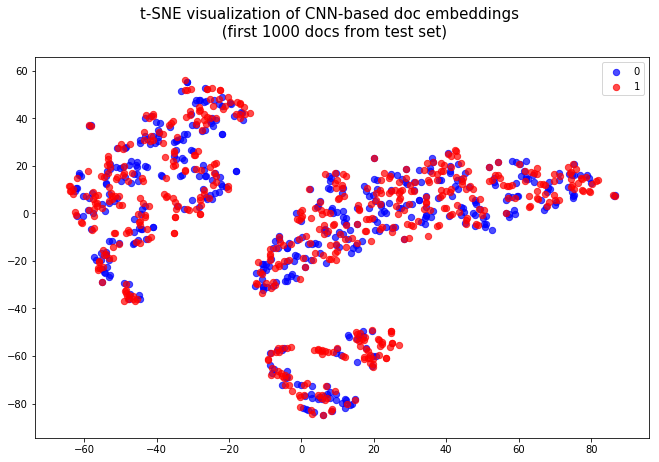

In [10]:
# = = = = = visualizing doc embeddings (before training) = = = = =

# you can access the layers of the model with model.layers
# then the input/output shape of each layer with, e.g., model.layers[0].input_shape or model.layers[0].output_shape

# extract output of the final embedding layer (before the softmax)
# in test mode, we should set the 'learning_phase' flag to 0 (e.g., we don't want to use dropout)
get_doc_embedding = K.function([model.layers[0].input,K.learning_phase()],
                               [model.layers[9].output])

n_plot = 1000
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(x_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

labels_plt = y_test[:n_plot]
my_colors = ['blue','red']

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=40)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=15)
fig.set_size_inches(11,7)
fig.show()


In [11]:
# = = = = = training = = = = =

# warning: by default on CPU, will use all cores
# reaches ~86% val accuracy in 4 epochs (8 secs/epoch on Titan GPU)

early_stopping = EarlyStopping(monitor='val_acc', # go through epochs as long as accuracy on validation set increases
                               patience=my_patience,
                               mode='max')

# save model corresponding to best epoch
checkpointer = ModelCheckpoint(filepath=path_to_data + 'model', 
                               verbose=1, 
                               save_best_only=True)


### fill the gap ###
# call the fit() method on model https://keras.io/models/model/ with the proper arguments
# convert x_train and x_test to numpy arrays

model.fit(np.array(x_train),
          y_train,
          batch_size = batch_size,
          epochs=nb_epochs, 
          validation_data = (np.array(x_test), y_test),
          callbacks = [early_stopping, checkpointer])

# to load pre-trained model, if necessary: model = load_model(path_to_data + 'model')

model = load_model(path_to_data + 'model')

Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 53s 2ms/step - loss: 0.6954 - acc: 0.5899 - val_loss: 0.5137 - val_acc: 0.7625

Epoch 00001: val_loss improved from inf to 0.51365, saving model to data/model
Epoch 2/6
25000/25000 [==============================] - 52s 2ms/step - loss: 0.4337 - acc: 0.7998 - val_loss: 0.3774 - val_acc: 0.8325

Epoch 00002: val_loss improved from 0.51365 to 0.37738, saving model to data/model
Epoch 3/6
25000/25000 [==============================] - 53s 2ms/step - loss: 0.3203 - acc: 0.8646 - val_loss: 0.3475 - val_acc: 0.8470

Epoch 00003: val_loss improved from 0.37738 to 0.34746, saving model to data/model
Epoch 4/6
25000/25000 [==============================] - 54s 2ms/step - loss: 0.2480 - acc: 0.9011 - val_loss: 0.3583 - val_acc: 0.8482

Epoch 00004: val_loss did not improve from 0.34746
Epoch 5/6
25000/25000 [==============================] - 54s 2ms/step - loss: 0.1949 - acc: 0.9240 - val_l

In [12]:
# = = = = = visualizing doc embeddings (after training) = = = = =

# perform the same steps as before training and observe the changes

# = = = = = predictive text regions for the first branch = = = = =

### fill the gap ###
# create a K.function named 'get_region_embedding' that extracts the region embeddings

get_region_embedding = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[3].output])

### fill the gap ###
# create a K.function named 'get_sigmoid' that extracts the final prediction

get_sigmoid = K.function([model.layers[0].input, K.learning_phase()], 
                         [model.layers[10].output])

my_review = x_test[10]

tokens = ['OOV' if elt==1 else index_to_word[elt] for elt in my_review if elt!=0]

# extract regions (sliding window over text)
regions = []
regions.append(' '.join(tokens[:filter_sizes[0]]))
for i in range(filter_sizes[0], len(tokens)):
    regions.append(' '.join(tokens[(i-filter_sizes[0]+1):(i+1)]))

my_review = np.array([my_review])

reg_emb = get_region_embedding([my_review,0])[0]

prediction = get_sigmoid([my_review,0])[0]

### fill the gap ###
# compute the norm of each row of reg_emb[0,:,:] using the np.linalg.norm function with the proper axis argument
# store the results as 'norms'
norms= np.linalg.norm(reg_emb[0,:,:], axis = 1 )[1:len(regions)]

norms = norms[1:len(regions)]

print([list(zip(regions,norms))[idx] for idx in np.argsort(-norms).tolist()])

[('head shaking events', 3.6999662), ('. a fun', 2.9191868), ('. the outstanding', 2.303448), ('fun , stylized', 2.2339406), ('a fun ,', 1.8676363), ('character was very', 1.7845027), ('backdrop of wwii', 1.7748835), ('each character was', 1.6364336), ('easily noted .', 1.5837687), ('the outstanding acting', 1.5605025), ('to bring together', 1.5534054), ('of wwii and', 1.5403429), ('wwii and succeeds', 1.4796356), ('on the development', 1.467421), ('very limited .', 1.4545383), ('noted . a', 1.4122252), ('limited . the', 1.3972436), ('manages to bring', 1.3742224), ('in the backdrop', 1.3584175), ('bring together seemingly', 1.2949692), ('characters and story', 1.2758597), ('with a slew', 1.1533817), ('individuals involved with', 1.1412346), ('much i really', 1.1359735), ('spent on the', 1.1355667), ('of each character', 1.1289295), ('i really felt', 1.1275939), ('really felt i', 1.1160092), ('time spent on', 1.1151937), ('different characters and', 1.0853639), ('how much i', 1.0745867

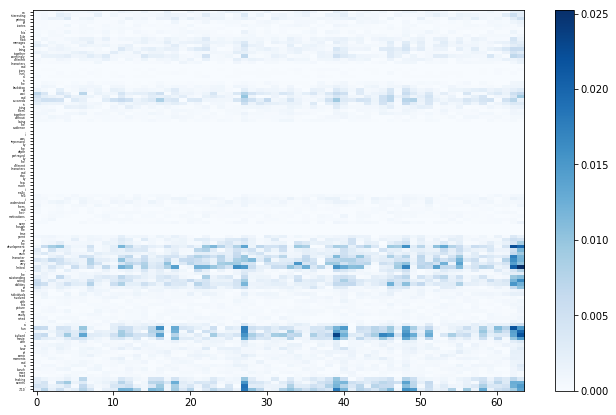

In [13]:
# = = = = = saliency map = = = = =

input_tensors = [model.input, K.learning_phase()]
saliency_input = model.layers[3].input # before convolution
saliency_output = model.layers[10].output # class score

gradients = model.optimizer.get_gradients(saliency_output,saliency_input)
compute_gradients = K.function(inputs=input_tensors,outputs=gradients)

### fill the gap ###
# save the result of compute_gradients as an object named 'matrix'
matrix = compute_gradients([my_review, 0])[0][0,:,:]

to_plot = np.absolute(matrix[:len(tokens),:])

fig, ax = plt.subplots()
heatmap = ax.imshow(to_plot, cmap=plt.cm.Blues, interpolation='nearest',aspect='auto')
ax.set_yticks(np.arange(len(tokens)))
ax.set_yticklabels(tokens)
ax.tick_params(axis='y', which='major', labelsize=32*10/len(tokens))
fig.colorbar(heatmap)
fig.set_size_inches(11,7)
fig.savefig(path_to_data + 'saliency_map.pdf',bbox_inches='tight')
fig.show()
